spark-submit --master yarn --deploy-mode cluster  --conf spark.yarn.submit.waitAppCompletion=false --conf spark.serializer=org.apache.spark.serializer.KryoSerializer --conf spark.speculation=false --conf spark.executorEnv.LANG=en_US.UTF-8 --conf spark.yarn.appMasterEnv.LANG=en_US.UTF-8 --driver-cores 20 --driver-memory 55G --num-executors 30 --executor-cores 15 --executor-memory 30G ./covid/py/get-summary-statistics-pyspark.py

In [1]:
import socket
import os

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf,desc,row_number,col,year,month,dayofmonth,dayofweek,to_timestamp,size,isnan,lit,date_format,to_timestamp
from pyspark.sql.types import MapType, StringType, IntegerType, StructType, StructField, FloatType, ArrayType, DoubleType

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import pandas as pd
from timeit import default_timer as timer

/share/apps/anaconda3/2019.10/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
try:
    spark
except NameError:
    spark=SparkSession.builder.appName("").getOrCreate()

In [3]:
source='cuebiq'
country='US'

if os.getenv('CLUSTER')=='PRINCE':
    path_to_data='/scratch/spf248/covid/data'
else:
    path_to_data='/user/spf248/covid/data'

In [4]:
date_range=pd.Series(sorted([
pd.to_datetime(x.split('/')[-1][:-2],format='%Y%m%d') 
for x in glob(os.path.join(path_to_data,source,country,'2020*'))]))

accuracy_threshold=100
activity_threshold=date_range.shape[0]*4//5
print('Activity Threshold:',activity_threshold)

Activity Threshold: 63


# Users Activity

In [5]:
print('Compute Users Statistics')
start = timer()

users=spark.read.parquet(os.path.join(path_to_data,source,country,'users'))
users.cache()

n_days=users.select('n_days').groupby('n_days').count().orderBy(desc('n_days')).toPandas()
n_days_active=users.select('n_days').filter(users['n_days']>=activity_threshold).groupby('n_days').count().orderBy(desc('n_days')).toPandas()
n_pings=users.select('n_pings').groupby('n_pings').count().orderBy(desc('n_pings')).toPandas()
n_pings_active=users.filter(users['n_days']>=activity_threshold).groupby('n_pings').count().orderBy(desc('n_pings')).toPandas()

total_pings=users.select('n_pings').groupby().sum().collect()[0][0]
total_users=n_days['count'].sum()
total_active_users=n_days_active['count'].sum()

print('# Users:', total_users)
print('# Users:', total_active_users)
print('# Pings:', total_pings)

print("Done in", round(timer()-start), "sec")

Compute Users Statistics
# Users: 33670866
# Users: 13179979
# Pings: 236911194574
Done in 348 sec


In [6]:
(users.groupby('device_type').count().toPandas().dropna().set_index('device_type')['count']/n_days['count'].sum()).round(2)

device_type
1.0    0.47
0.0    0.53
Name: count, dtype: float64

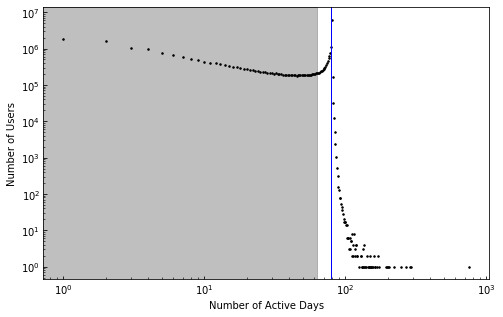

In [7]:
fig,ax=plt.subplots(figsize=(8,5))
n_days.set_index('n_days')['count'].plot(ax=ax,style='.',color='k', markersize=3)
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(which='both',direction='in',pad=3)
ax.set_xlabel('Number of Active Days')
ax.set_ylabel('Number of Users')
ax.axvline(x=(date_range.max()-date_range.min()).days+1, color='b', linewidth=1)
ax.axvspan(0, activity_threshold, alpha=0.5, color='grey')

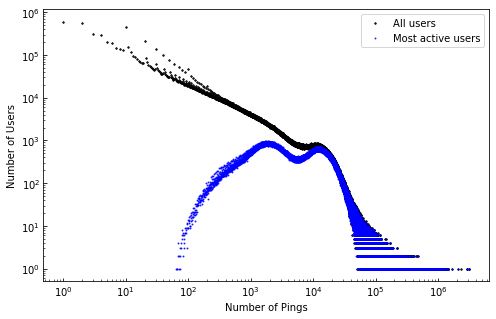

In [8]:
fig,ax=plt.subplots(figsize=(8,5))
n_pings.set_index('n_pings')['count'].plot(ax=ax,style='*',markersize=2,alpha=0.75,color='k',label='All users')
n_pings_active.set_index('n_pings')['count'].plot(ax=ax,style='.',markersize=2,alpha=0.75,color='b',label='Most active users')
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(which='both',direction='in',pad=3)
ax.set_xlabel('Number of Pings')
ax.set_ylabel('Number of Users')
ax.legend(loc='best')

# Pings Accuracy

In [9]:
print('Compute Users Statistics')
start = timer()

accuracy=spark.read.parquet(os.path.join(path_to_data,source,country,'accuracy')).toPandas()

print("Done in", round(timer()-start), "sec")

Compute Users Statistics
Done in 16 sec


Text(100000, 1853395.0, '(P(A<100)=0.96')

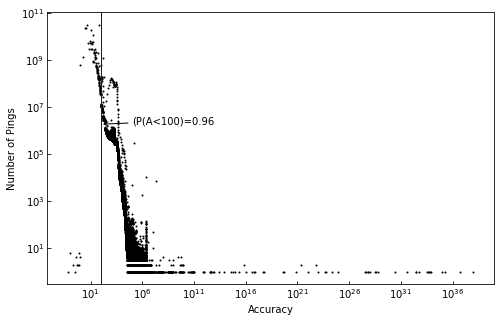

In [10]:
fig,ax=plt.subplots(figsize=(8,5))
accuracy.set_index('accuracy')['count'].plot(ax=ax,style='.',color='k', markersize=2)
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(which='both',direction='in',pad=3)
ax.set_xlabel('Accuracy')
ax.set_ylabel('Number of Pings')
ax.axvline(x=accuracy_threshold, color='b', linewidth=1)
plt.annotate(
'(P(A<'+str(accuracy_threshold)+')='+str(round(accuracy[accuracy.accuracy<=accuracy_threshold]['count'].sum()/accuracy['count'].sum(),2)), 
xy=(accuracy_threshold,accuracy.accuracy.iloc[accuracy.shape[0]*9//10]),
xytext=(accuracy_threshold*1000,accuracy.accuracy.iloc[accuracy.shape[0]*9//10]) ,
horizontalalignment="left",
arrowprops=dict(arrowstyle='->',lw=1)
)

# Personal Areas

In [11]:
print('Compute Users Statistics')
start = timer()

personal=spark.read.parquet(os.path.join(path_to_data,source,country,'personal'))
personal.cache()

users=users.join(personal.groupby('cuebiq_id').count().withColumnRenamed('count','n_personal'),on='cuebiq_id')

n_personal=personal.groupby('cuebiq_id').count().withColumnRenamed(
"count", "n_personal").groupby('n_personal').count().toPandas()

print("Done in", round(timer()-start), "sec")

Compute Users Statistics
Done in 398 sec


Text(0, 0.5, 'Number of Users')

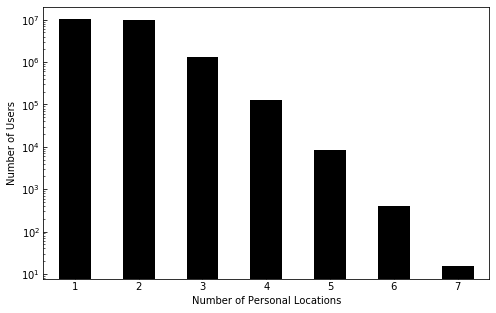

In [12]:
fig,ax=plt.subplots(figsize=(8,5))
n_personal.set_index('n_personal')['count'].sort_index().plot(ax=ax,kind='bar',color='k')
ax.tick_params(which='both',direction='in',pad=3)
plt.xticks(rotation=0)
ax.set_yscale('log')
ax.set_xlabel('Number of Personal Locations')
ax.set_ylabel('Number of Users')

In [13]:
print('Most Frequent Hour At Personal location')
start = timer()

def get_most_freq_hour(personal_value,device_type,activity_value):
    return personal.join(users.filter(
    users['n_personal']==personal_value).filter(
    users['device_type']==device_type).filter(
    users['n_days']>activity_value).select(
    'cuebiq_id'),on='cuebiq_id').groupby('most_freq_hour').count().toPandas()

most_freq_hour={}
for personal_value in [1,2,3]:
    print('personal_value:',personal_value)
    for device_type in [0,1]:
        print('device_type:',device_type)
        for activity_value in [0,activity_threshold]:
            print('activity_value:',activity_value)
            most_freq_hour[(personal_value,device_type,activity_value)]=\
            get_most_freq_hour(personal_value,device_type,activity_value)

print("Done in", round(timer()-start), "sec")

Most Frequent Hour At Personal location
personal_value: 1
device_type: 0
activity_value: 0
activity_value: 63
device_type: 1
activity_value: 0
activity_value: 63
personal_value: 2
device_type: 0
activity_value: 0
activity_value: 63
device_type: 1
activity_value: 0
activity_value: 63
personal_value: 3
device_type: 0
activity_value: 0
activity_value: 63
device_type: 1
activity_value: 0
activity_value: 63
Done in 2715 sec


personal_value: 1
device_type: 0
activity_value: 0
activity_value: 63
device_type: 1
activity_value: 0
activity_value: 63
personal_value: 2
device_type: 0
activity_value: 0
activity_value: 63
device_type: 1
activity_value: 0
activity_value: 63
personal_value: 3
device_type: 0
activity_value: 0
activity_value: 63
device_type: 1
activity_value: 0
activity_value: 63


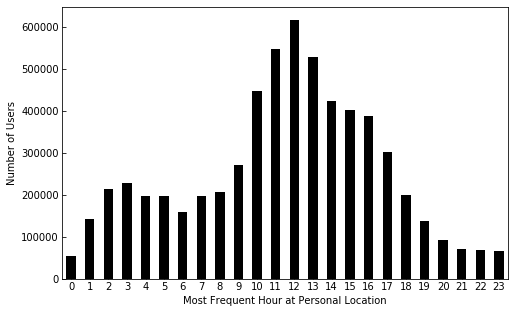

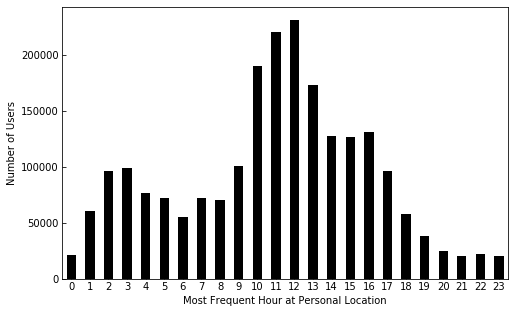

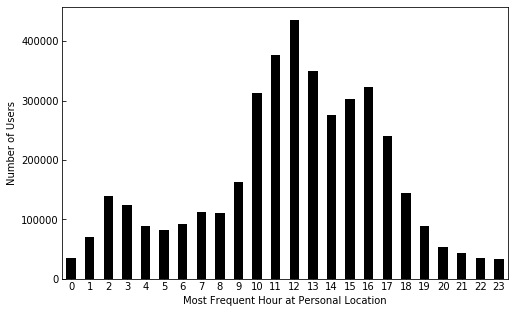

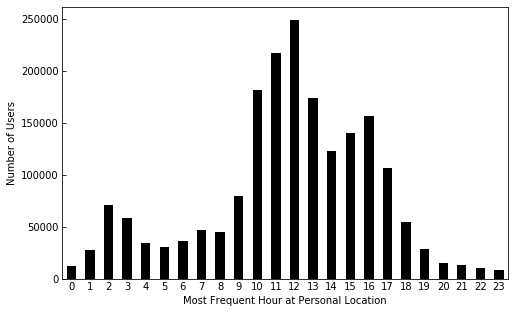

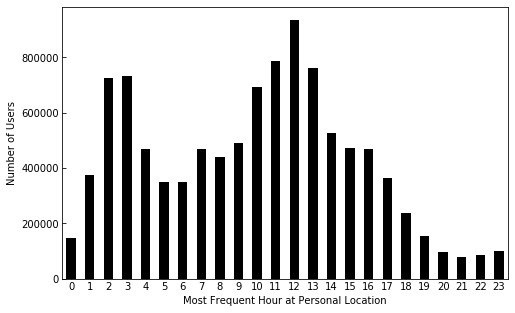

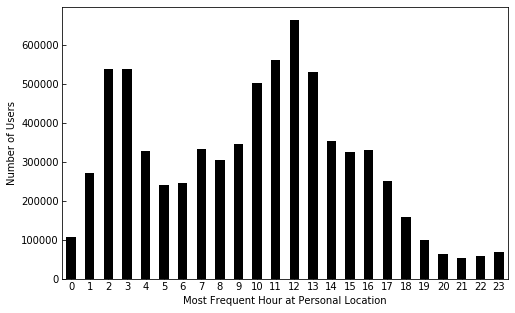

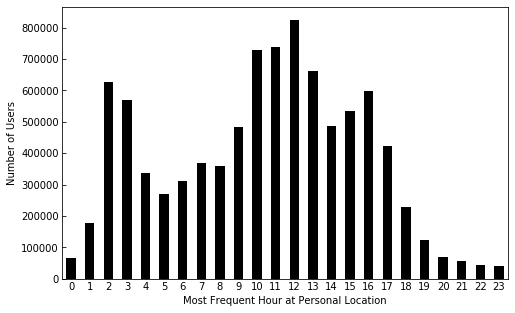

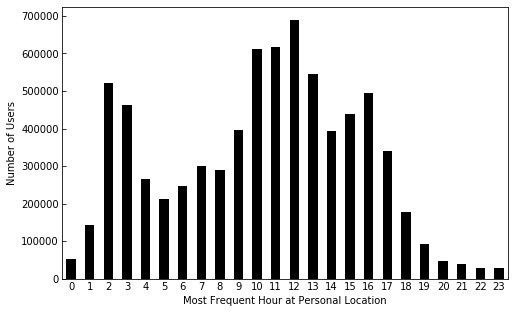

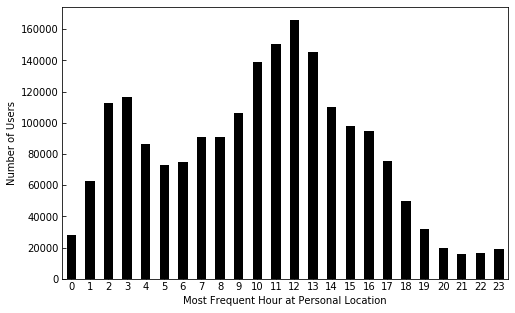

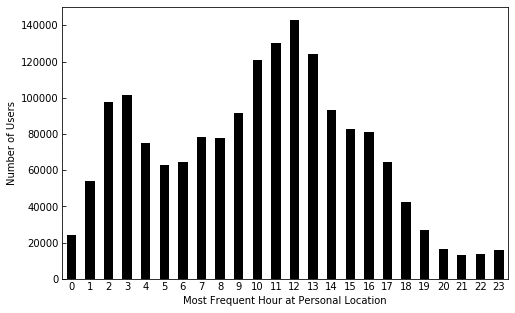

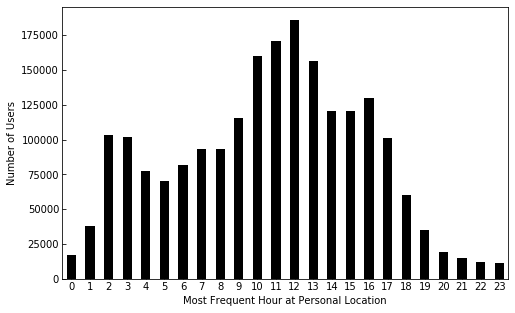

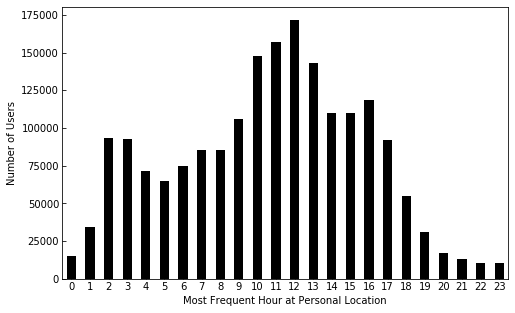

In [20]:
for personal_value in [1,2,3]:
    print('personal_value:',personal_value)
    for device_type in [0,1]:
        print('device_type:',device_type)
        for activity_value in [0,activity_threshold]:
            print('activity_value:',activity_value)
            try:
                fig,ax=plt.subplots(figsize=(8,5))
                most_freq_hour[(personal_value,device_type,activity_value)].set_index(
                'most_freq_hour')['count'].sort_index().plot(ax=ax,kind='bar',color='k')
                ax.tick_params(which='both',direction='in',pad=3)
                plt.xticks(rotation=0)
                ax.set_xlabel('Most Frequent Hour at Personal Location')
                ax.set_ylabel('Number of Users')
                plt.savefig(os.path.join(
                path_to_data+'/../fig','most-freq-hour-'+str(personal_value)+'-'+str(device_type)+'-'+str(activity_value)+'.pdf'),
                bbox_inches='tight')
            except:
                pass